In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, roc_curve, auc, 
                             classification_report, adjusted_rand_score, normalized_mutual_info_score,
                             silhouette_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

sns.set_theme(style="whitegrid")

In [69]:
np.random.seed(42) # random state

In [70]:
# 1. VERİ YÜKLEME VE BÖLME

# Wine Dataset Load
data = load_wine()
X = data.data # type: ignore
y = data.target # type: ignore
feature_names = data.feature_names # type: ignore
target_names = data.target_names # type: ignore

print(f"Data Shape: {X.shape}")
print(f"Classes: {target_names}")

# Data Bölme: 70% Train, 10% Val, 20% Test
# Split 1: Split Test (20%) and Temp (80%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Split 2 Train (70%) and Val (10%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42
)

print(f"Train Size: {X_train.shape[0]} (yaklaşık %70)")
print(f"Val Size:   {X_val.shape[0]} (yaklaşık %10)")
print(f"Test Size:  {X_test.shape[0]} (yaklaşık %20)")

Data Shape: (178, 13)
Classes: ['class_0' 'class_1' 'class_2']
Train Size: 124 (yaklaşık %70)
Val Size:   18 (yaklaşık %10)
Test Size:  36 (yaklaşık %20)


In [71]:
# Evaluation metrikleri için fonksiyon
def get_metrics(model, X_set, y_set, dataset_name="Val"):
    y_pred = model.predict(X_set)
    # Check if model supports predict_proba for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_set)
        # OvR for Multi-class Wine
        roc_auc = roc_auc_score(y_set, y_prob, multi_class='ovr', average='macro')
    else:
        # If no probability (rare for these models with correct settings), set to NaN or skip
        roc_auc = np.nan
        
    return {
        "Model": dataset_name,
        "Accuracy": accuracy_score(y_set, y_pred),
        "Precision (Macro)": precision_score(y_set, y_pred, average='macro', zero_division=0),
        "Recall (Macro)": recall_score(y_set, y_pred, average='macro'),
        "F1-Score (Macro)": f1_score(y_set, y_pred, average='macro'),
        "ROC-AUC (OvR)": roc_auc
    }

In [72]:
# Store validation results
validation_results = []

In [73]:
# KNN SINIFLANDIRMA (KNN CLASSIFICATION)

# Pipeline: Scaler + KNN
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Hyperparameter Space
# n_neighbors: 1-31 
k_values = list(range(1, 32, 2))
knn_params = {
    'knn__n_neighbors': k_values,
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2] # Manhattan vs Euclidean
}


In [74]:
# 7.1 Baseline KNN (n_neighbors=5)
baseline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])
baseline_knn.fit(X_train, y_train)

y_val_pred_baseline = baseline_knn.predict(X_val)
baseline_f1 = f1_score(y_val, y_val_pred_baseline, average='macro')
print(f"Baseline KNN (k=5) Validation F1: {baseline_f1:.4f}")

Baseline KNN (k=5) Validation F1: 1.0000


Best KNN Params: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}


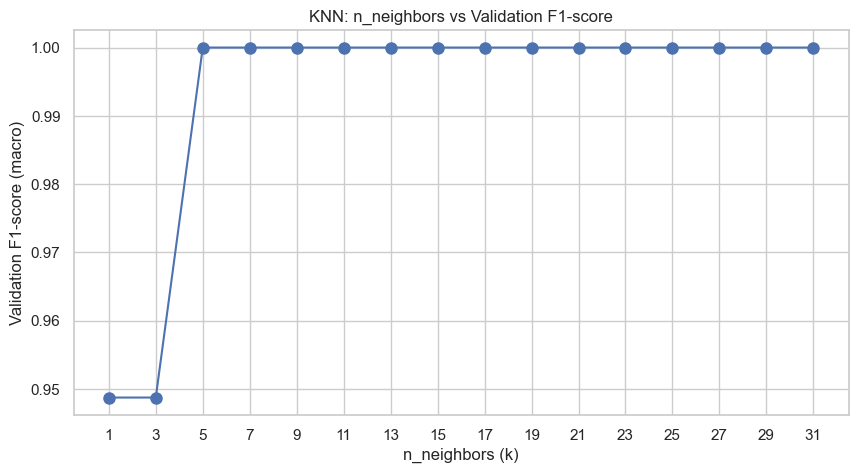

In [75]:
# Grid Search (keep this for finding best params)
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
knn_grid.fit(X_train, y_train)

print(f"Best KNN Params: {knn_grid.best_params_}")
best_knn = knn_grid.best_estimator_

best_w = knn_grid.best_params_['knn__weights']
best_p = knn_grid.best_params_['knn__p']

# n_neighbors vs Validation F1 Grafiği
n_neighbors_list = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]
val_f1_scores = []

for n in n_neighbors_list:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(
            n_neighbors=n
        ))
    ])
    pipe.fit(X_train, y_train)
    y_val_pred = pipe.predict(X_val)
    val_f1_scores.append(f1_score(y_val, y_val_pred, average='macro'))

# Grafik
plt.figure(figsize=(10, 5))
plt.plot(n_neighbors_list, val_f1_scores, 'b-o', markersize=8)
plt.xlabel('n_neighbors (k)')
plt.ylabel('Validation F1-score (macro)')
plt.title('KNN: n_neighbors vs Validation F1-score')
plt.xticks(n_neighbors_list)
plt.grid(True)
plt.show()

In [76]:
# Evaluate KNN on Validation Set
knn_val_metrics = get_metrics(best_knn, X_val, y_val, "KNN")
knn_val_metrics["Model"] = "KNN"
knn_val_metrics["Best Params"] = str(knn_grid.best_params_)
validation_results.append(knn_val_metrics)
print(validation_results)

[{'Model': 'KNN', 'Accuracy': 1.0, 'Precision (Macro)': 1.0, 'Recall (Macro)': 1.0, 'F1-Score (Macro)': 1.0, 'ROC-AUC (OvR)': 1.0, 'Best Params': "{'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}"}]


In [77]:
# SVM SINIFLANDIRMA (SVM CLASSIFICATION)

# Pipeline ve parametreler
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42)) # probability=True
])

svm_params = [
    # Linear Kernel
    {
        'svm__kernel': ['linear'],
        'svm__C': [0.01, 0.1, 1, 10, 100]
    },
    # RBF Kernel
    {
        'svm__kernel': ['rbf'],
        'svm__C': [0.01, 0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1]
    }
]

svm_grid = GridSearchCV(svm_pipe, svm_params, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
svm_grid.fit(X_train, y_train)

print(f"Best SVM Params: {svm_grid.best_params_}")
best_svm = svm_grid.best_estimator_

# Evaluate on Validation Set
# svm_val_metrics = get_metrics(best_svm, X_val, y_val, "SVM")
# svm_val_metrics["Model"] = f"SVM ({svm_grid.best_params_['svm__kernel']})"
# svm_val_metrics["Best Params"] = str(svm_grid.best_params_)
#validation_results.append(svm_val_metrics)
#print(svm_val_metrics)

Best SVM Params: {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


In [78]:
# En iyi Lineer ve RBF karşılaştırması (Validation üstünde)

# Get best params for each kernel from GridSearchCV results
results_df = pd.DataFrame(svm_grid.cv_results_)

# Best Linear params
linear_results = results_df[results_df['param_svm__kernel'] == 'linear']
best_linear_idx = linear_results['mean_test_score'].idxmax()
best_linear_C = results_df.loc[best_linear_idx, 'param_svm__C']

# Best RBF params
rbf_results = results_df[results_df['param_svm__kernel'] == 'rbf']
best_rbf_idx = rbf_results['mean_test_score'].idxmax()
best_rbf_C = results_df.loc[best_rbf_idx, 'param_svm__C']
best_rbf_gamma = results_df.loc[best_rbf_idx, 'param_svm__gamma']

# Train best Linear SVM and evaluate on validation
best_linear_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=best_linear_C, probability=True, random_state=42)) # type: ignore
])
best_linear_pipe.fit(X_train, y_train)
linear_val_metrics = get_metrics(best_linear_pipe, X_val, y_val, "SVM (Linear)")

# Train best RBF SVM and evaluate on validation
best_rbf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=best_rbf_C, gamma=best_rbf_gamma, probability=True, random_state=42)) # type: ignore
])
best_rbf_pipe.fit(X_train, y_train)
rbf_val_metrics = get_metrics(best_rbf_pipe, X_val, y_val, "SVM (RBF)")

# Compare
comparison_df = pd.DataFrame([linear_val_metrics, rbf_val_metrics])
print(comparison_df)

#En iyi lineer ve rbf validation sonuçlarına ekle
linear_val_metrics["Best Params"] = f"C={best_linear_C}"
rbf_val_metrics["Best Params"] = f"C={best_rbf_C}, gamma={best_rbf_gamma}"

validation_results.append(linear_val_metrics)
validation_results.append(rbf_val_metrics)

          Model  Accuracy  Precision (Macro)  Recall (Macro)  \
0  SVM (Linear)       1.0                1.0             1.0   
1     SVM (RBF)       1.0                1.0             1.0   

   F1-Score (Macro)  ROC-AUC (OvR)  
0               1.0            1.0  
1               1.0            1.0  


Best MLP Params: {'mlp__activation': 'relu', 'mlp__alpha': 1e-05, 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.01}


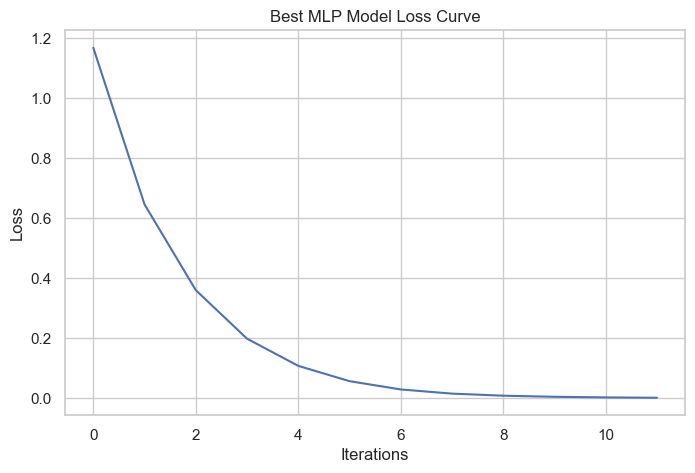

In [79]:
#  MLP SINIFLANDIRMA (MLP CLASSIFICATION)

# Pipeline: Scaler + MLP
mlp_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=500, random_state=42)) # max iter ve random state belirlenmiştir
])

# Hyperparameter Space
mlp_params = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [1e-5, 1e-4, 1e-3, 1e-2],
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__early_stopping': [True]
}

mlp_grid = GridSearchCV(mlp_pipe, mlp_params, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
mlp_grid.fit(X_train, y_train)

print(f"Best MLP Params: {mlp_grid.best_params_}")
best_mlp = mlp_grid.best_estimator_

# Zorunlu Plot: Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(best_mlp.named_steps['mlp'].loss_curve_)
plt.title("Best MLP Model Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Evaluate on Validation Set
mlp_val_metrics = get_metrics(best_mlp, X_val, y_val, "MLP")
mlp_val_metrics["Model"] = "MLP"
mlp_val_metrics["Best Params"] = str(mlp_grid.best_params_)
validation_results.append(mlp_val_metrics)

In [80]:
# VALIDATION COMPARISON 

val_df = pd.DataFrame(validation_results)

val_df = val_df[["Model", "Accuracy", "Precision (Macro)", "Recall (Macro)", "F1-Score (Macro)", "ROC-AUC (OvR)", "Best Params"]]
display(val_df)

,Model,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro),ROC-AUC (OvR),Best Params
0,KNN,1.000000,1.000000,1.000000,1.000000,1.000000,"{'knn__n_neighbors': 9, 'knn__p': 1, 'knn__wei..."
1,SVM (Linear),1.000000,1.000000,1.000000,1.000000,1.000000,C=1.0
2,SVM (RBF),1.000000,1.000000,1.000000,1.000000,1.000000,"C=100.0, gamma=0.01"
3,MLP,0.944444,0.958333,0.933333,0.940741,0.979487,"{'mlp__activation': 'relu', 'mlp__alpha': 1e-0..."


Seçilen Model : KNN
Best Params: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}

Test Seti İçin Metrikler
Model: TEST SET
Accuracy: 0.9722222222222222
Precision (Macro): 0.9743589743589745
Recall (Macro): 0.9761904761904763
F1-Score (Macro): 0.974320987654321
ROC-AUC (OvR): 1.0


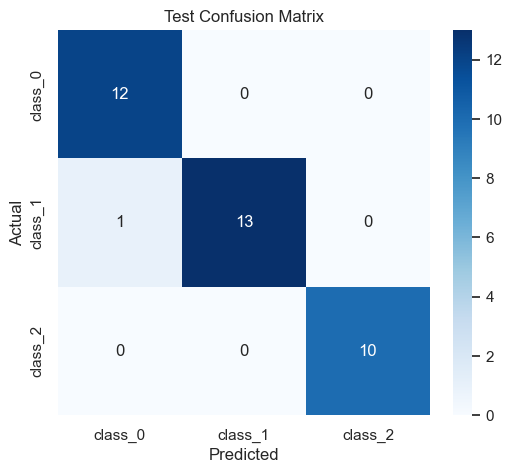

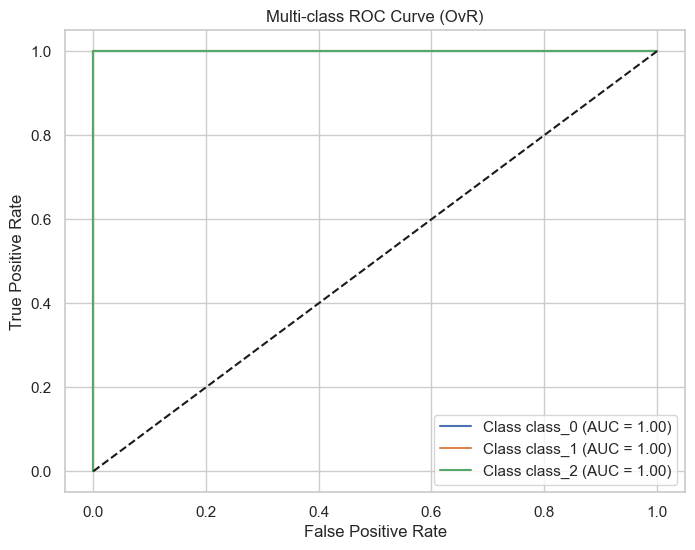

In [81]:
# En iyi Modeli Test Üstünde Değerlendirme

# Birden fazla iyi model vardır. KNN seçilmiştir
final_model = best_knn
print(f"Seçilen Model : KNN")
print(f"Best Params: {knn_grid.best_params_}")

# Test Metrics
test_metrics = get_metrics(final_model, X_test, y_test, "TEST SET")
print("\nTest Seti İçin Metrikler")
for k, v in test_metrics.items():
    print(f"{k}: {v}")

# Confusion Matrix Heatmap
y_pred_test = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve (Multiclass OvR)
# We plot ROC for each class vs Rest
y_prob_test = final_model.predict_proba(X_test)
plt.figure(figsize=(8, 6))

for i, class_name in enumerate(target_names):
    fpr, tpr, _ = roc_curve(y_test == i, y_prob_test[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc_class:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (OvR)')
plt.legend(loc='lower right')
plt.show()

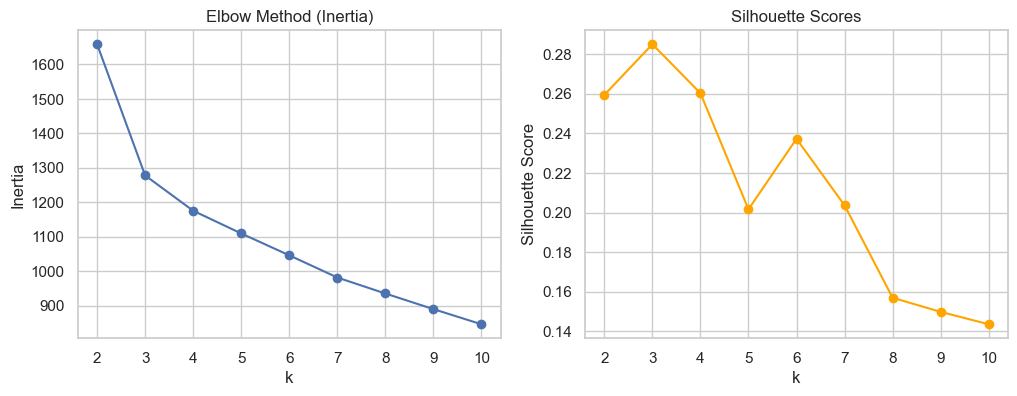

In [87]:

# KMEANS  
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

X_cluster = X_scaled # Ham ölçeklenmiş veri

inertia = []
silhouette_scores = []
k_range = range(2, 11)

# Loop k=2..10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster, kmeans.labels_))

# Elbow Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")

# Silhouette Plot
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Scores")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()

In [ ]:
#  k=3 (Wine da 3 class var ve Elbow grafiği de orda kırılıyor
chosen_k = 3
print(f"Selected k: {chosen_k} (Wine setinde 3 class var ve Elbow grafiği k=3'de kırılıyor)")

final_kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
clusters = final_kmeans.fit_predict(X_cluster) #Sadece X 

# ARI & NMI
ari = adjusted_rand_score(y, clusters)
nmi = normalized_mutual_info_score(y, clusters)
print(f"\nKMeans (k={chosen_k}) Performance vs True Labels:")
print(f"ARI: {ari:.4f}")
print(f"NMI: {nmi:.4f}")

Selected k: 3 (Wine setinde 3 class var ve Elbow grafiği k=3'de kırılıyor)

KMeans (k=3) Performance vs True Labels:
ARI: 0.8975
NMI: 0.8759


Variance yüksek olan özellikler: proline (var=98609.60), magnesium (var=202.84)

Cluster ayrışması daha hoş gözüktüğü için Alcohol vs Flavanoids seçişmiştir.


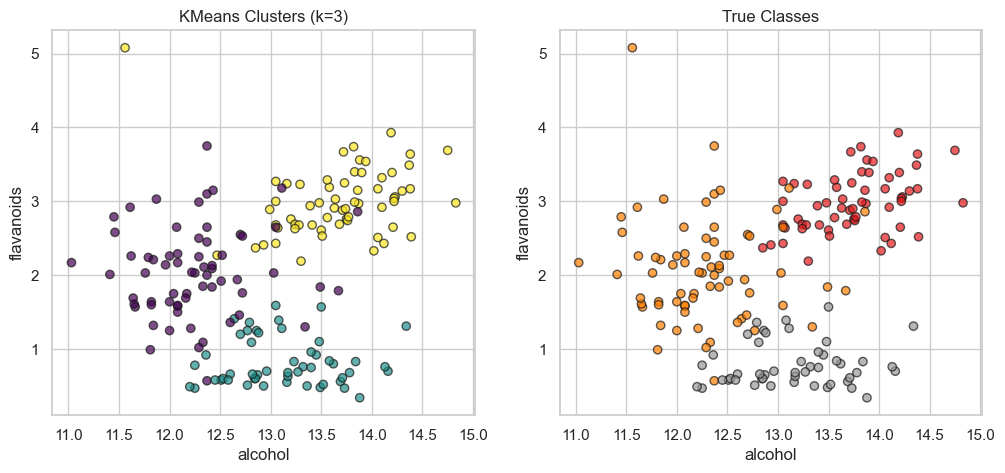

In [95]:
# Görselleştirme 
# Select two highest variance features
variances = np.var(X, axis=0)
top2_idx = np.argsort(variances)[-2:][::-1]
f1_idx, f2_idx = top2_idx[0], top2_idx[1]
f1_name, f2_name = feature_names[f1_idx], feature_names[f2_idx]

print(f"Variance yüksek olan özellikler: {f1_name} (var={variances[f1_idx]:.2f}), {f2_name} (var={variances[f2_idx]:.2f})")

print("\nCluster ayrışması daha hoş gözüktüğü için Alcohol vs Flavanoids seçişmiştir.")
# Index 0: Alcohol, Index 6: Flavanoids (commonly distinct in wine)
f1_idx, f2_idx = 0, 6
f1_name, f2_name = feature_names[f1_idx], feature_names[f2_idx]

plt.figure(figsize=(12, 5))

# Plot 1: Colored by Cluster
plt.subplot(1, 2, 1)
plt.scatter(X[:, f1_idx], X[:, f2_idx], c=clusters, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title(f"KMeans Clusters (k={chosen_k})")
plt.xlabel(f1_name)
plt.ylabel(f2_name)

# Plot 2: Colored by True Class
plt.subplot(1, 2, 2)
plt.scatter(X[:, f1_idx], X[:, f2_idx], c=y, cmap='Set1', edgecolor='k', alpha=0.7)
plt.title("True Classes")
plt.xlabel(f1_name)
plt.ylabel(f2_name)

plt.show()

In [98]:
# Küme Profili

df_wine = pd.DataFrame(X, columns=feature_names)
df_wine['Cluster'] = clusters
print("\nCluster Profiles (Mean Values):")
display(df_wine.groupby('Cluster').mean().T)

print("\nYorum için en çok ayrıştıran 5 feature")
# Calculate variance across clusters to find most differentiating features
cluster_means = df_wine.groupby('Cluster').mean()
feature_variance = cluster_means.var()
top5_features = feature_variance.nlargest(5).index.tolist()

for feat in top5_features:
    values = cluster_means[feat]
    print(f"{feat}: " + ", ".join([f"Cluster {i}={v:.2f}" for i, v in values.items()]))


Cluster Profiles (Mean Values):


Cluster,0,1,2
alcohol,12.250923,13.134118,13.676774
malic_acid,1.897385,3.307255,1.997903
ash,2.231231,2.417647,2.466290
alcalinity_of_ash,20.063077,21.241176,17.462903
magnesium,92.738462,98.666667,107.967742
total_phenols,2.247692,1.683922,2.847581
flavanoids,2.050000,0.818824,3.003226
nonflavanoid_phenols,0.357692,0.451961,0.292097
proanthocyanins,1.624154,1.145882,1.922097
color_intensity,2.973077,7.234706,5.453548



Yorum için en çok ayrıştıran 5 feature
proline: Cluster 0=510.17, Cluster 1=619.06, Cluster 2=1100.23
magnesium: Cluster 0=92.74, Cluster 1=98.67, Cluster 2=107.97
color_intensity: Cluster 0=2.97, Cluster 1=7.23, Cluster 2=5.45
alcalinity_of_ash: Cluster 0=20.06, Cluster 1=21.24, Cluster 2=17.46
flavanoids: Cluster 0=2.05, Cluster 1=0.82, Cluster 2=3.00


Background samples: 100
Explanation samples: 50

Calculating SHAP values (bu biraz zaman alabilir)...


  0%|          | 0/18 [00:00<?, ?it/s]


--- SHAP Summary Plot ---


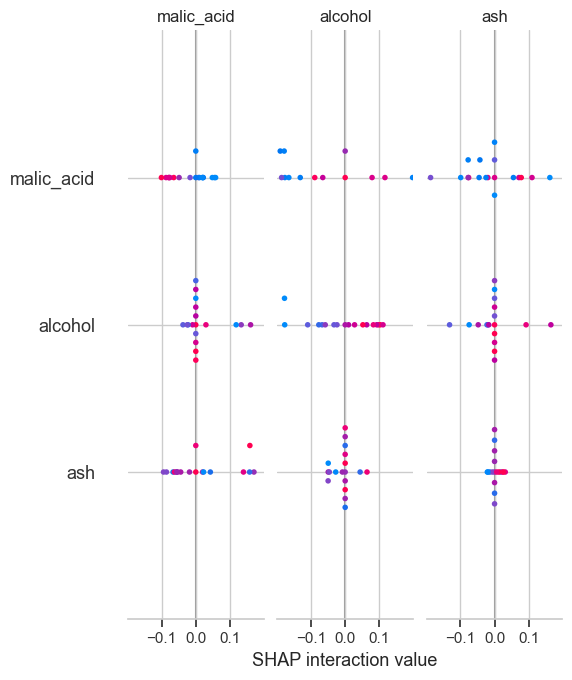


--- SHAP Bar Plot (Mean |SHAP|) ---


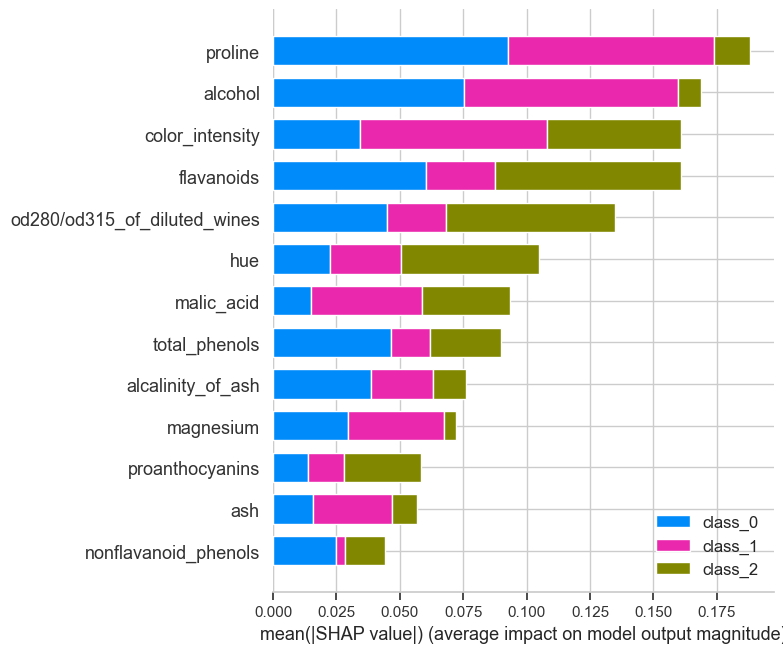

In [102]:
#  SHAP Analysis (KNN için - en iyi model)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# KNN için scaler'dan geçmiş veri lazım
X_train_scaled = best_knn.named_steps['scaler'].transform(X_train)
X_val_scaled = best_knn.named_steps['scaler'].transform(X_val)

# Background ve explanation subset (hesap maliyeti için sınırlandırılmış)
background_size = 100
explain_size = 50  # KernelExplainer yavaş olduğu için daha küçük

np.random.seed(42)
background_idx = np.random.choice(X_train_scaled.shape[0], size=background_size, replace=False)
background = X_train_scaled[background_idx]

explain_idx = np.random.choice(X_val_scaled.shape[0], size=min(explain_size, X_val_scaled.shape[0]), replace=False)
X_explain = X_val_scaled[explain_idx]

print(f"Background samples: {background_size}")
print(f"Explanation samples: {explain_size}")

# KernelExplainer
# predict_proba çıktısı kullanılıyor
knn_classifier = best_knn.named_steps['knn']
explainer = shap.KernelExplainer(knn_classifier.predict_proba, background)

# SHAP values hesapla
print("\nCalculating SHAP values (bu biraz zaman alabilir)...")
shap_values = explainer.shap_values(X_explain)

# 13.1 Summary Plot
print("\n--- SHAP Summary Plot ---")
shap.summary_plot(shap_values, X_explain, feature_names=feature_names, class_names=target_names)

# 13.1 Bar Plot (mean |SHAP|)
print("\n--- SHAP Bar Plot (Mean |SHAP|) ---")
shap.summary_plot(shap_values, X_explain, feature_names=feature_names, plot_type="bar", class_names=target_names)

In [101]:
# Mean |SHAP| importance across all classes
print("\n--- Feature Importance (Mean |SHAP|) ---")
mean_shap = np.abs(np.array(shap_values)).mean(axis=(0, 1))
for feat, val in sorted(zip(feature_names, mean_shap), key=lambda x: -x[1]):
    print(f"{feat}: {val:.4f}")


--- Feature Importance (Mean |SHAP|) ---
alcohol: 0.0396
malic_acid: 0.0375
ash: 0.0314
